# **Import & Image Data**


In [ ]:
!pip install albumentations==0.4.6
!unzip " "

In [2]:
import re, sys, glob, time, os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm

from PIL import Image
import cv2 as cv

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import Dataset, DataLoader

torch.__version__, torchvision.__version__

('1.10.0+cu111', '0.11.1+cu111')

# **Functions**

In [3]:
def labelizer(x):
  if x == 'fruit_woodiness':
    return 1
  elif x == 'fruit_brownspot':
    return 2
  else:
    return 3

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], fill=False, edgecolor=color, linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

# **Loads Data**

In [4]:
train_df = pd.read_csv('Train.csv', sep=',')

save_path = 'fasterrcnn_resnet50_fpn.pth'

train_df = train_df.rename(columns={'Image_ID':'image_id','xmin':'x','ymin':'y','width':'w','height':'h'})
train_df[['x','y','w','h']] = train_df[['x','y','w','h']].astype(np.float32)
train_df['class'] = train_df['class'].apply(lambda x:labelizer(x))

print(train_df.shape)
print(train_df.info())
train_df.head(8)

(3906, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906 entries, 0 to 3905
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  3906 non-null   object 
 1   class     3906 non-null   int64  
 2   x         3906 non-null   float32
 3   y         3906 non-null   float32
 4   w         3906 non-null   float32
 5   h         3906 non-null   float32
dtypes: float32(4), int64(1), object(1)
memory usage: 122.2+ KB
None


image_id  class      x      y      w      h
0  ID_007FAIEI      1   87.0   87.5  228.0  311.0
1  ID_00G8K1V3      2   97.5   17.5  245.0  354.5
2  ID_00WROUT9      2  156.5  209.5  248.0  302.5
3  ID_00ZJEEK3      3  125.0  193.0  254.5  217.0
4  ID_018UIENR      2   79.5  232.5  233.5  182.0
5  ID_01QZDXVQ      1  139.5  238.5  285.5  231.5
6  ID_02PX7GI8      2    1.5   94.5  256.0  236.0
7  ID_02PX7GI8      2  124.0  352.5  160.5  159.5

# **Split Data**

In [5]:
image_ids = train_df['image_id'].unique()

split_len = round(len(image_ids)*0.9)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = train_df[train_df['image_id'].isin(train_ids)].reset_index(drop=True)
valid = train_df[train_df['image_id'].isin(valid_ids)].reset_index(drop=True)

y_train = train['class'].values
y_val = valid['class'].values

train.shape, valid.shape

((3525, 6), (381, 6))

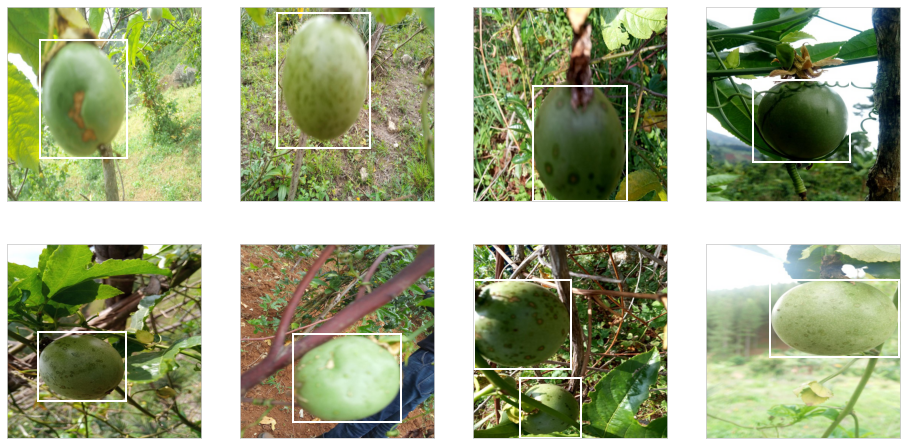

In [14]:
num_rows, num_cols = 2, 4, 
ids = train_df['image_id'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'/content/Train_Images/{n}.jpg') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=4)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['image_id'] == id]
  bboxes = [(d['x'], d['y'], d['x']+d['w'], d['y']+d['h']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

# **Pytorch Data Loader**

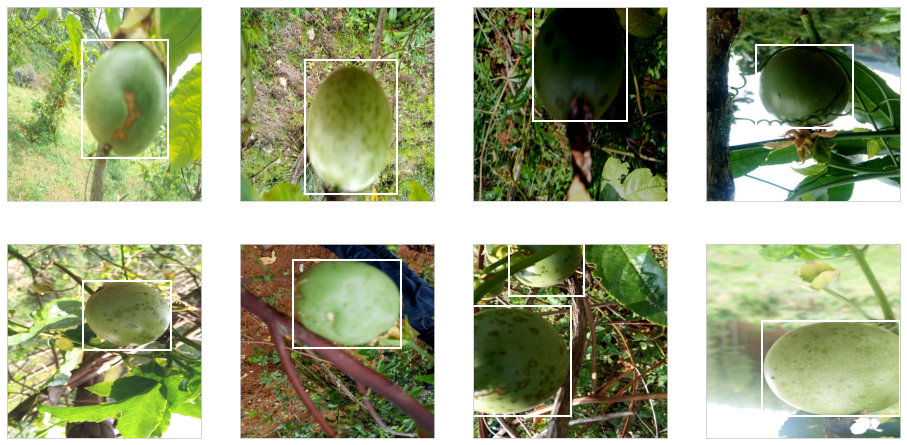

In [13]:
class Fruit(Dataset):
  def __init__(self, dataframe, image_dir, label=None, transforms=None):
    super().__init__()
    self.image_ids = dataframe['image_id'].unique()
    self.df = dataframe
    self.image_dir = image_dir
    self.transforms = transforms
    self.label = label

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]
    records = self.df[self.df['image_id'] == image_id]
    label = self.label[records.index]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    boxes = records[['x', 'y', 'w', 'h']].values
    area = torch.as_tensor(boxes[:, 2] * boxes[:, 3], dtype=torch.float32)

    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    labels = torch.Tensor(label).type(torch.int64) 
    iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx])
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms:
      sample = {'image': image, 'bboxes': target['boxes'], 'labels': labels,}
      sample = self.transforms(**sample)
      image = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0).type(torch.float32)

    return image, target, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  # Albumentations
  # https://github.com/albumentations-team/albumentations

  @staticmethod
  def get_train_transform():
    return A.Compose([
                      A.Flip(0.5), 
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                      A.CenterCrop(height=416, width=416, p=0.25),
                      ToTensorV2(p=1.0),
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  @staticmethod
  def get_valid_transform():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_dataset = Fruit(train, '/content/Train_Images', y_train, Fruit.get_train_transform())
valid_dataset = Fruit(valid, '/content/Train_Images', y_val, Fruit.get_valid_transform())

datas = [train_dataset[i] for i in range(8)]
imgs = [d[0].permute(1, 2, 0).numpy() for d in datas]
axes = show_images(imgs, 2, 4, scale=4)
for ax, (image, target, image_id) in zip(axes, datas):
  show_bboxes(ax, target['boxes'], labels=None, colors=['w'])
plt.show()

# **Model: Faster R-CNN**

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
print(model.roi_heads.box_predictor)

num_classes = 4 # 3 class + background

# get and replace number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
    )

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
    )

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create an optimizer
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.01, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)
# lr_scheduler = None

num_epochs = 6

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=4, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=16, bias=True)
)
Adjusting learning rate of group 0 to 1.0000e-02.


# **Training**

In [9]:
itr = 1
total_train_loss, total_valid_loss = [], []
min_loss_valid = np.inf
losses_value = 0

# scaler = torch.cuda.amp.GradScaler()  # for mixed-precision

for epoch in range(num_epochs):
  start_time = time.time()

  # train ------------------------------
  model.train()
  train_loss = []
  pbar = tqdm(train_data_loader, desc='let\'s train')
  for images, targets, image_ids in pbar:
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)

    losses = sum(loss.type(torch.double) for loss in loss_dict.values())
    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    # # with autocast() for mixed-precision
    # with torch.cuda.amp.autocast():  
    #   loss_dict = model(images, targets)

    # losses = sum(loss.type(torch.double) for loss in loss_dict.values())
    # losses_value = losses.item()
    # train_loss.append(losses_value)   

    # scaler.scale(losses).backward()  # for mixed-precision
    # scaler.step(optimizer)  # for mixed-precision
    # scaler.update()  # for mixed-precision

    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
  
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()

  # valid ------------------------------
  with torch.no_grad():
    valid_loss = []

    for images, targets, image_ids in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
        
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)

  # print & save ------------------------------
  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

  # save best model state
  if epoch_valid_loss < min_loss_valid:
    min_loss_valid = epoch_valid_loss
    torch.save(model.state_dict(), save_path) # save model state
    print(f"Best model saved -> Valid Loss: {epoch_valid_loss}")

let's train:   0%|          | 0/338 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch Completed: 1/6, Time: 1261.7520356178284, Train Loss: 0.1567581135264447, Valid Loss: 0.09101512322300359
Best model saved -> Valid Loss: 0.09101512322300359


let's train:   0%|          | 0/338 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch Completed: 2/6, Time: 1259.5362513065338, Train Loss: 0.0933339720330657, Valid Loss: 0.06456763816899375
Best model saved -> Valid Loss: 0.06456763816899375


let's train:   0%|          | 0/338 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch Completed: 3/6, Time: 1260.8492352962494, Train Loss: 0.0685918718609496, Valid Loss: 0.06354060837704885
Best model saved -> Valid Loss: 0.06354060837704885


let's train:   0%|          | 0/338 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch Completed: 4/6, Time: 1260.8404293060303, Train Loss: 0.05705360058802194, Valid Loss: 0.053722057001371136
Best model saved -> Valid Loss: 0.053722057001371136


let's train:   0%|          | 0/338 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch Completed: 5/6, Time: 1257.7055730819702, Train Loss: 0.05475856828862028, Valid Loss: 0.050599994137883186
Best model saved -> Valid Loss: 0.050599994137883186


let's train:   0%|          | 0/338 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch Completed: 6/6, Time: 1257.7911581993103, Train Loss: 0.0541913338225027, Valid Loss: 0.0508733575085276


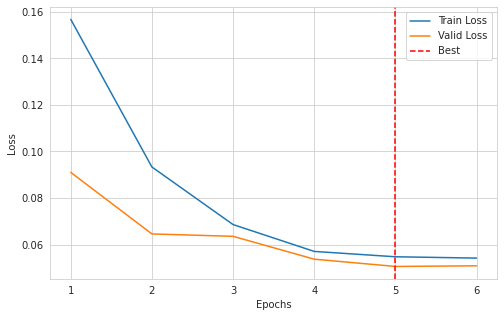

In [12]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.axvline(np.array(total_train_loss).argmin(-1), label=f'Best', color='r', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()